<p style="font-family: helvetica,arial,sans-serif; font-size:2.0em;color:white; background-color: black;">&emsp;<b>EDA: Compare Pedestrian Traffic Day and Night</b></p>
    
<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Authored by: </b> Barkha Javed</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black; text-align:right"> <b>Duration:</b> 45 mins&emsp;</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Level: </b>Beginner&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<b>Pre-requisite Skills:</b>Python</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>Scenario</b>

# Business & Activity 
As a small business owner, I want to understand how covid affected foot traffic, and how long it might take to return to normal. I'd also like deeper insights into how different activities can impact pedestrian traffic.

 Factors impacting traffic include those listed below, we will be examining some of these in depth:
- Seasonality through temperature, severe weather events,  daylight savings, public holidays such as Christmas, school holidays, 
- Time of day, day of week
- Major events such as the AFL, concerts and exhibitions
- Proximity to public transport: Trains / Buses / Trams
- Number of local residences
- Number of people travelling into the CBD
- Covid cases and status
- Other venues in proximity - schools, universities, parks, retail outlets, restaurants, bars, clubs, cinemas

This exploratory data analysis looks at <b><i>Time of day, day of week impact on foot traffic</i></b>.

## Data Preparation

In [59]:
# pip -q is to give less output
!pip -q install sodapy
!pip -q install seaborn
!pip -q install pandas
!pip -q install matplotlib
!pip -q install numpy
!pip -q install nbconvert
!pip -q install keyboard
!pip -q install sklearn

In [99]:
#load libraries
import pandas as pd
import numpy as np
import requests
import io
import keyboard
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sodapy import Socrata

import warnings
warnings.filterwarnings('ignore')

### Data Acquisition Pedestrian Sensor Locations

In [29]:
#Location data
client = Socrata('data.melbourne.vic.gov.au', '9UAGAvkem9fqXDhBLElapjazL', None)
sensor_data_id = "h57g-5234"
results = client.get(sensor_data_id)
sensor_location = pd.DataFrame.from_records(results)
#sensor_location.head(5)

sensor_location[['latitude', 'longitude']] = sensor_location[['latitude', 'longitude']].astype(float)
sensor_location = sensor_location.drop('location',axis=1)

#View sensor data
sensor_location.info()
sensor_location.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_id           91 non-null     object 
 1   sensor_description  91 non-null     object 
 2   sensor_name         91 non-null     object 
 3   installation_date   91 non-null     object 
 4   status              91 non-null     object 
 5   note                10 non-null     object 
 6   latitude            91 non-null     float64
 7   longitude           91 non-null     float64
 8   direction_1         78 non-null     object 
 9   direction_2         78 non-null     object 
dtypes: float64(2), object(8)
memory usage: 7.2+ KB


,sensor_id,sensor_description,sensor_name,installation_date,status,note,latitude,longitude,direction_1,direction_2
0,16,Australia on Collins,Col270_T,2009-03-30T00:00:00.000,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,NaN,NaN
1,50,Faraday St-Lygon St (West),Lyg309_T,2017-11-30T00:00:00.000,A,NaN,-37.798082,144.967210,South,North
2,73,Bourke St - Spencer St (South),Bou655_T,2020-10-02T00:00:00.000,I,NaN,-37.816957,144.954154,East,West
3,66,State Library - New,QVN_T,2020-04-06T00:00:00.000,A,NaN,-37.810578,144.964443,South,North
4,59,Building 80 RMIT,RMIT_T,2019-02-13T00:00:00.000,A,NaN,-37.808256,144.963049,South,North


### Data Acquisition Pedestrian Traffic

In [30]:
##Pedestrian foot count data 
sensor_data_id = "b2ak-trbp"

##Uncomment lines below to open data source, download sensor data, and store it as a csv locally.
#results = client.get(sensor_data_id, limit=7000000)
#ds_traffic = pd.DataFrame.from_records(results)
#ds_traffic.to_csv('sensor_traffic.csv', index=False)

sensor_traffic = pd.read_csv('sensor_traffic.csv')
sensor_traffic.info()

print(f'\nThe shape of dataset is {sensor_traffic.shape}. \n')
print('Below are the first few rows of this dataset: ')
sensor_traffic.head(10)

#convert data types for merge
sensor_traffic['sensor_id']=sensor_traffic['sensor_id'].astype(int)
sensor_location['sensor_id']=sensor_location['sensor_id'].astype(int)

sensor_ds = pd.merge(sensor_traffic, sensor_location, on='sensor_id')
sensor_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463670 entries, 0 to 4463669
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   date_time      object
 2   year           int64 
 3   month          object
 4   mdate          int64 
 5   day            object
 6   time           int64 
 7   sensor_id      int64 
 8   sensor_name    object
 9   hourly_counts  int64 
dtypes: int64(6), object(4)
memory usage: 340.6+ MB

The shape of dataset is (4463670, 10). 

Below are the first few rows of this dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463670 entries, 0 to 4463669
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   date_time      object
 2   year           int64 
 3   month          object
 4   mdate          int64 
 5   day            object
 6   time           int64 
 7   sensor_id      int32 
 8   sensor_name    object
 9   hourly_

In [31]:
#Add date column
sensor_traffic['date'] = pd.to_datetime(sensor_traffic.date_time).dt.date

#Add day of week column
sensor_traffic['dow'] = pd.to_datetime(sensor_traffic.date_time).dt.day_of_week

sensor_traffic.head(10)

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,date,dow
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300,2019-11-01,4
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604,2019-11-01,4
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216,2019-11-01,4
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627,2019-11-01,4
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774,2019-11-01,4
5,2887633,2019-11-01T17:00:00.000,2019,November,1,Friday,17,29,St Kilda Rd-Alexandra Gardens,644,2019-11-01,4
6,2887634,2019-11-01T17:00:00.000,2019,November,1,Friday,17,42,Grattan St-Swanston St (West),453,2019-11-01,4
7,2887635,2019-11-01T17:00:00.000,2019,November,1,Friday,17,43,Monash Rd-Swanston St (West),387,2019-11-01,4
8,2887636,2019-11-01T17:00:00.000,2019,November,1,Friday,17,44,Tin Alley-Swanston St (West),27,2019-11-01,4
9,2887637,2019-11-01T17:00:00.000,2019,November,1,Friday,17,35,Southbank,2691,2019-11-01,4


In [32]:
# Mesh pedestrian sensor location and foot traffic datasets

#convert sensor_id to integer
sensor_traffic['sensor_id']=sensor_traffic['sensor_id'].astype(int)
sensor_location['sensor_id']=sensor_location['sensor_id'].astype(int)

sensor_ds = pd.merge(sensor_traffic, sensor_location, on='sensor_id')

#Add column
sensor_ds['installation_dt'] = pd.to_datetime(sensor_ds.installation_date).dt.date

#Simply using the year to differentiate all the years prior to 2020 as before Covid, and post 2019 Covid traffic to now
sensor_ds['pre2020_hourly_counts'] = np.where(sensor_ds['year']<=2019,sensor_ds['hourly_counts'] , 0)
sensor_ds['post2019_hourly_counts'] = np.where(sensor_ds['year']>2019,sensor_ds['hourly_counts'] , 0)

#Add column for day (5am to 5pm) or night (6pm to 4am) traffic
sensor_ds['day_counts']   = np.where(((sensor_ds['time']>4)  & (sensor_ds['time']<18)),sensor_ds['hourly_counts'] , 0)
sensor_ds['night_counts'] = np.where(sensor_ds['day_counts']==0,sensor_ds['hourly_counts'], 0)

#Drop column
sensor_ds = sensor_ds.drop(['installation_date','status','note','sensor_name_x'],axis=1)

sensor_ds.info()
sensor_ds.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463670 entries, 0 to 4463669
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   date_time               object 
 2   year                    int64  
 3   month                   object 
 4   mdate                   int64  
 5   day                     object 
 6   time                    int64  
 7   sensor_id               int32  
 8   hourly_counts           int64  
 9   date                    object 
 10  dow                     int64  
 11  sensor_description      object 
 12  sensor_name_y           object 
 13  latitude                float64
 14  longitude               float64
 15  direction_1             object 
 16  direction_2             object 
 17  installation_dt         object 
 18  pre2020_hourly_counts   int64  
 19  post2019_hourly_counts  int64  
 20  day_counts              int64  
 21  night_counts            int64  

,id,year,mdate,time,sensor_id,hourly_counts,dow,latitude,longitude,pre2020_hourly_counts,post2019_hourly_counts,day_counts,night_counts
count,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06
mean,2.232320e+06,2.017230e+03,1.574741e+01,1.146917e+01,2.700226e+01,4.951352e+02,2.999995e+00,-3.781345e+01,1.449621e+02,4.074119e+02,8.772332e+01,3.594659e+02,1.356693e+02
std,1.289316e+06,3.551188e+00,8.800020e+00,6.938594e+00,1.951539e+01,7.509822e+02,2.000015e+00,6.187582e-03,8.531568e-03,7.443612e+02,2.852713e+02,7.131327e+02,3.910920e+02
min,1.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.782402e+01,1.449297e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.115918e+06,2.015000e+03,8.000000e+00,5.000000e+00,1.100000e+01,4.300000e+01,1.000000e+00,-3.781874e+01,1.449587e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.231836e+06,2.018000e+03,1.600000e+01,1.100000e+01,2.300000e+01,1.780000e+02,3.000000e+00,-3.781381e+01,1.449651e+02,6.200000e+01,0.000000e+00,2.400000e+01,0.000000e+00
75%,3.347753e+06,2.020000e+03,2.300000e+01,1.700000e+01,4.100000e+01,6.050000e+02,5.000000e+00,-3.781102e+01,1.449669e+02,4.530000e+02,2.400000e+01,3.520000e+02,5.900000e+01
max,4.469141e+06,2.022000e+03,3.100000e+01,2.300000e+01,8.700000e+01,1.597900e+04,6.000000e+00,-3.779432e+01,1.449747e+02,1.597900e+04,1.443700e+04,1.161200e+04,1.597900e+04


In [33]:
sensor_ds.head(10)

,id,date_time,year,month,mdate,day,time,sensor_id,hourly_counts,date,...,sensor_name_y,latitude,longitude,direction_1,direction_2,installation_dt,pre2020_hourly_counts,post2019_hourly_counts,day_counts,night_counts
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,300,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,300,0,300,0
1,2887683,2019-11-01T18:00:00.000,2019,November,1,Friday,18,34,240,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,240,0,0,240
2,2887738,2019-11-01T19:00:00.000,2019,November,1,Friday,19,34,158,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,158,0,0,158
3,2887793,2019-11-01T20:00:00.000,2019,November,1,Friday,20,34,118,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,118,0,0,118
4,2887848,2019-11-01T21:00:00.000,2019,November,1,Friday,21,34,131,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,131,0,0,131
5,2887903,2019-11-01T22:00:00.000,2019,November,1,Friday,22,34,218,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,218,0,0,218
6,2887958,2019-11-01T23:00:00.000,2019,November,1,Friday,23,34,154,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,154,0,0,154
7,2888013,2019-11-02T00:00:00.000,2019,November,2,Saturday,0,34,21,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,21,0,0,21
8,2888068,2019-11-02T01:00:00.000,2019,November,2,Saturday,1,34,21,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,21,0,0,21
9,2888123,2019-11-02T02:00:00.000,2019,November,2,Saturday,2,34,4,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,4,0,0,4


### Seperate day and night data sets

In [34]:
flag_value=0
df_day=sensor_ds.query("day_counts > @flag_value")
print('Day info \n',df_day.info(),'\n')

df_night=sensor_ds.query("day_counts == @flag_value")
print('Night info \n',df_night.info(),'\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2402520 entries, 0 to 4463663
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   date_time               object 
 2   year                    int64  
 3   month                   object 
 4   mdate                   int64  
 5   day                     object 
 6   time                    int64  
 7   sensor_id               int32  
 8   hourly_counts           int64  
 9   date                    object 
 10  dow                     int64  
 11  sensor_description      object 
 12  sensor_name_y           object 
 13  latitude                float64
 14  longitude               float64
 15  direction_1             object 
 16  direction_2             object 
 17  installation_dt         object 
 18  pre2020_hourly_counts   int64  
 19  post2019_hourly_counts  int64  
 20  day_counts              int64  
 21  night_counts            int64  

## Examine Pedestrian Traffic Hourly Counts

In [35]:
#examine hourly foot traffic, sort and examine just the hourly counts, to see distribution and outliers
ds = pd.DataFrame(sensor_ds["hourly_counts"])
ds.info()
df = ds.sort_values(by=['hourly_counts'], ascending=False)
rs = df.value_counts()
print('\n Hourly Counts in descending order', rs, '\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463670 entries, 0 to 4463669
Data columns (total 1 columns):
 #   Column         Dtype
---  ------         -----
 0   hourly_counts  int64
dtypes: int64(1)
memory usage: 68.1 MB

 Hourly Counts in descending order hourly_counts
0                75117
1                50592
2                50422
3                46444
4                44498
                 ...  
6117                 1
6118                 1
6119                 1
6124                 1
15979                1
Length: 6410, dtype: int64 



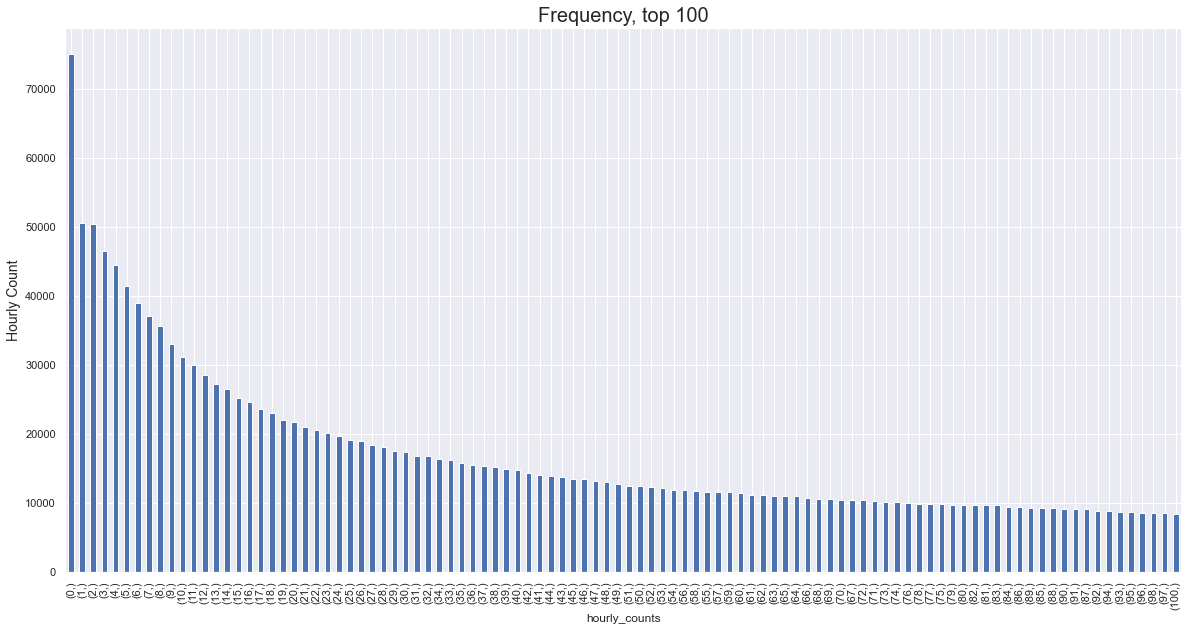

In [36]:
axs = rs[:100].plot.bar(figsize=(20, 10), rot = 90)
axs.set_title('Frequency, top 100', size=20)
axs.set_ylabel('Hourly Count', size=14)
plt.show()


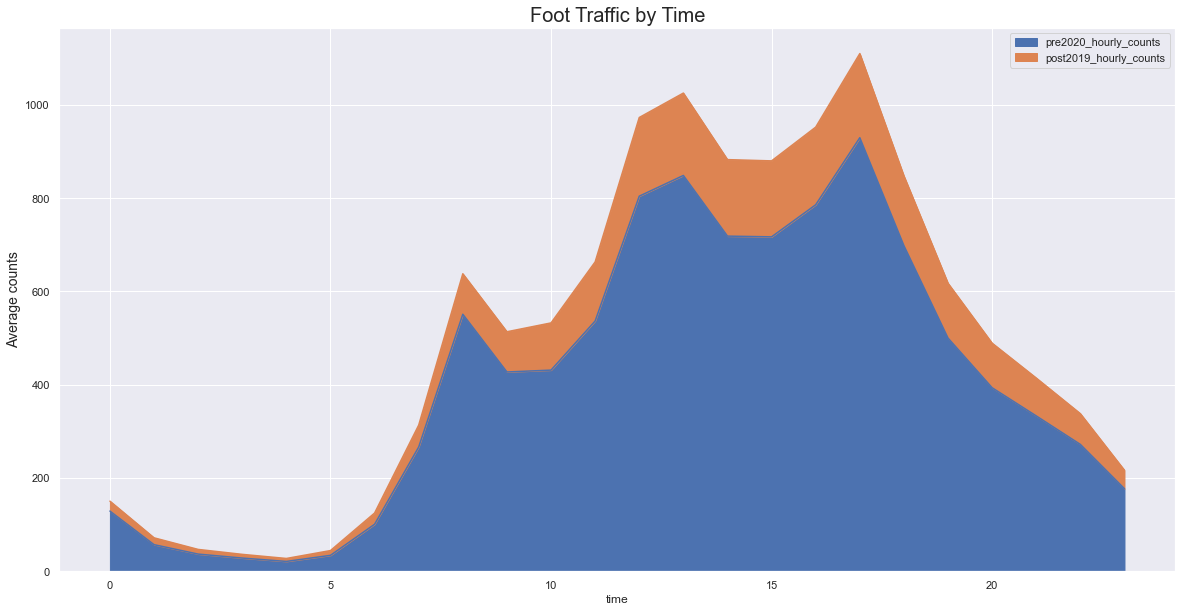

In [37]:
#examine pre Covid and post 2019 foot traffic
ds = pd.DataFrame(sensor_ds.groupby(["time"])["pre2020_hourly_counts","post2019_hourly_counts"].mean())
df = ds.sort_values(by=['time'])
axs = df.plot.area(figsize=(20, 10))
axs.set_title('Foot Traffic by Time', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()


## Examine Pedestrian Traffic by Weekday 

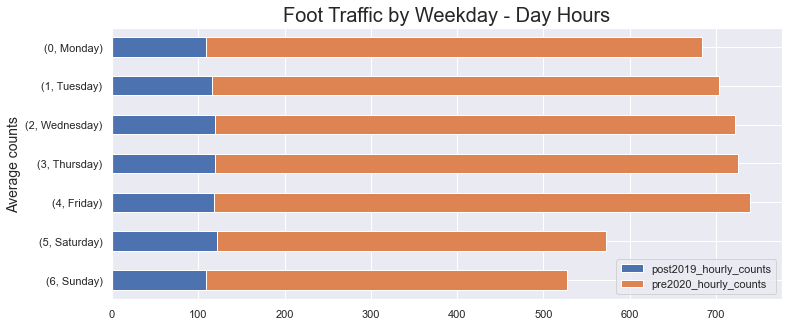

               post2019_hourly_counts  pre2020_hourly_counts
dow day                                                     
0   Monday                 108.672732             575.217959
1   Tuesday                115.421740             588.282018
2   Wednesday              119.291492             602.673719
3   Thursday               119.240018             606.327427
4   Friday                 118.037838             621.057157
5   Saturday               121.193445             451.183935
6   Sunday                 109.023656             418.899238


In [42]:
#distribution by traffic, by day - Covid impact on day
df_day['pre2020_hourly_counts'] = np.where(df_day['year']<=2019,df_day['hourly_counts'] , 0)
pivot = pd.pivot_table(df_day, values=["pre2020_hourly_counts","post2019_hourly_counts"], index=['dow','day'], aggfunc=np.mean)
rs = pivot.sort_values(by='dow', ascending = False)
axs =rs.plot.barh(figsize=(12, 5), stacked=True);

axs.set_title('Foot Traffic by Weekday - Day Hours', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

print(pivot)


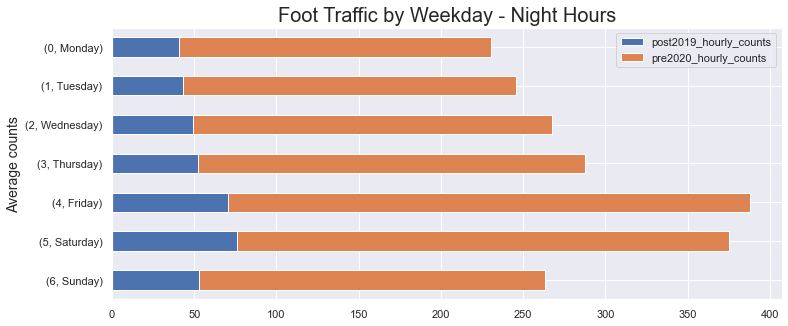

               post2019_hourly_counts  pre2020_hourly_counts
dow day                                                     
0   Monday                  40.560096             189.703862
1   Tuesday                 43.002026             202.723255
2   Wednesday               49.214528             218.310429
3   Thursday                52.259859             235.018921
4   Friday                  70.742168             316.916047
5   Saturday                76.157817             298.691270
6   Sunday                  52.664457             210.678895


In [44]:
#distribution by traffic, by night - Covid impact on night
df_night['pre2020_hourly_counts'] = np.where(df_night['year']<=2019,df_night['night_counts'] , 0)
pivot = pd.pivot_table(df_night, values=["pre2020_hourly_counts","post2019_hourly_counts"], index=['dow','day'], aggfunc=np.mean)
rs = pivot.sort_values(by='dow', ascending = False)
axs =rs.plot.barh(figsize=(12, 5), stacked=True);

axs.set_title('Foot Traffic by Weekday - Night Hours', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

print(pivot)

## Examine Pedestrian Traffic by Day and Night

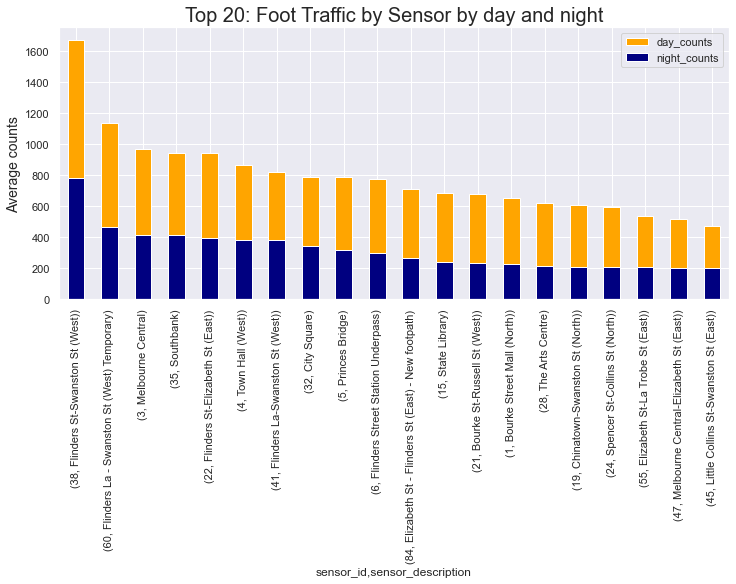

In [45]:
#distribution by traffic, by day
pivot = pd.pivot_table(sensor_ds, values='day_counts', index=['sensor_id','sensor_description'], aggfunc=np.mean)
pivot_ds = pivot['day_counts'].nlargest(n=20)
pivot_ds.plot.bar(figsize=(12, 5), color='orange', legend=True);

#by night
pivot = pd.pivot_table(sensor_ds, values='night_counts', index=['sensor_id','sensor_description'], aggfunc=np.mean)
pivot_ds = pivot['night_counts'].nlargest(n=20)
axs = pivot_ds.plot.bar(figsize=(12, 5), color='navy', legend=True);

axs.set_title('Top 20: Foot Traffic by Sensor by day and night', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

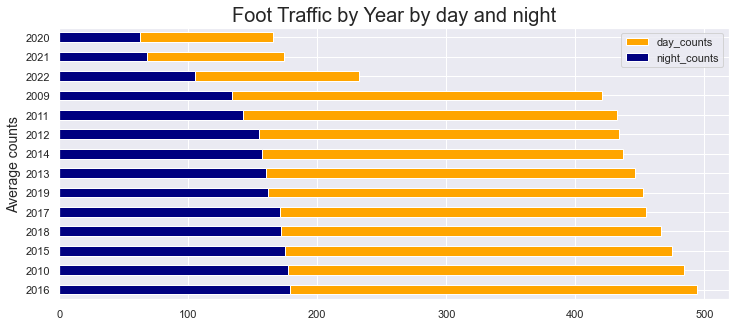

In [46]:
#distribution by traffic, by day
pivot = pd.DataFrame(pd.pivot_table(sensor_ds, values='day_counts', index=['year'], aggfunc=np.mean))
pivot_ds = pivot['day_counts'].nlargest(n=20)
pivot_ds.plot.barh(figsize=(12, 5), color='orange', legend=True);

#by night
pivot = pd.DataFrame(pd.pivot_table(sensor_ds, values='night_counts', index=['year'], aggfunc=np.mean))
pivot_ds = pivot['night_counts'].nlargest(n=20)
axs = pivot_ds.plot.barh(figsize=(12, 5), color='navy', legend=True);

axs.set_title('Foot Traffic by Year by day and night', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

## Clustering Analysis

### Examine: All Hours

In [92]:
#identify class and features
class_list = ["sensor_id"]
features_list = ["mdate", "dow","hourly_counts"]

#separate class and features - all hours
df_class = pd.DataFrame(sensor_ds[class_list])
df_features_all = pd.DataFrame(sensor_ds[features_list])

#examine data
df_features_all.describe()

,mdate,dow,hourly_counts
count,4.463670e+06,4.463670e+06,4.463670e+06
mean,1.574741e+01,2.999995e+00,4.951352e+02
std,8.800020e+00,2.000015e+00,7.509822e+02
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,1.000000e+00,4.300000e+01
50%,1.600000e+01,3.000000e+00,1.780000e+02
75%,2.300000e+01,5.000000e+00,6.050000e+02
max,3.100000e+01,6.000000e+00,1.597900e+04


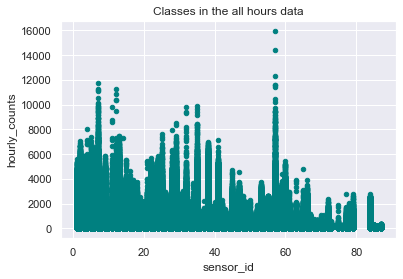

There are several classes in the all hours data


In [88]:
#how many classes are there in the data
sensor_ds.plot(kind="scatter",x="sensor_id",y="hourly_counts", color='Teal')
plt.title('Classes in the all hours data')
plt.show()
print("There are several classes in the all hours data")

### Examine: Day Hours

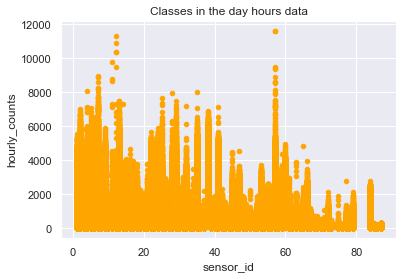

There are several classes in the day hours


In [96]:
features_list = ["mdate", "dow","day_counts"]
#separate class and features - day hours
df_class = pd.DataFrame(df_day[class_list])
df_features = pd.DataFrame(df_day[features_list])

#examine data
df_features.describe()#separate class and features - day hours only 

#plot classses
df_day.plot(kind="scatter",x="sensor_id",y="hourly_counts", color='Orange')
plt.title('Classes in the day hours data')
plt.show()
print("There are several classes in the day hours")

### Examine: Night Hours

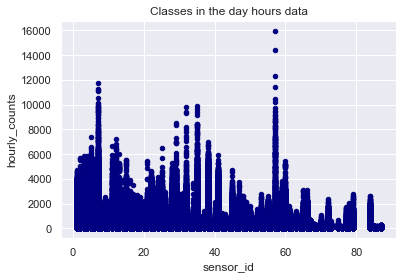

There are several classes in the night hours


In [97]:
features_list = ["mdate", "dow","night_counts"]

#separate class and features - night hours
df_class = pd.DataFrame(df_night[class_list])
df_features_night = pd.DataFrame(df_night[features_list])

#examine data
df_features_night.describe()#separate class and features - night hours only 

#separate class and features - night hours only 
df_night.plot(kind="scatter",x="sensor_id",y="hourly_counts", color='Navy')
plt.title('Classes in the day hours data')
plt.show()
print("There are several classes in the night hours")

Day, night and all hours look similar in terms of classes, will further examine day hours

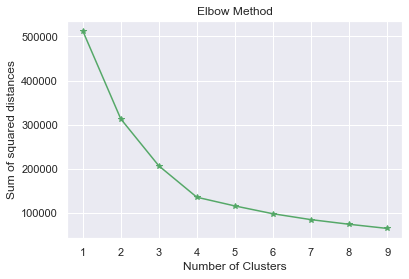

In [91]:
#scale the features, excluding class
mms = MinMaxScaler()
mms.fit(df_features) #day hours
data_transformed = mms.transform(df_features)

#data_transformed

# for each k value calculate sum of squared distances to the nearest cluster centre
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
#plot results
plt.plot(K, Sum_of_squared_distances, 'g*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

Using the elbow method on the features dataset, the optimal number of clusters is 4


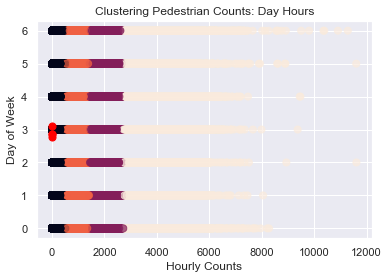

Predicted        0       1       2       3      All
True                                               
1            18149   14914   10634   12558    56255
2            20736   16750   13063   12250    62799
3            20187   21545   14671    3561    59964
4            16561   12234    9629   19565    57989
5            16708   21377   19107    3918    61110
...            ...     ...     ...     ...      ...
84             704     995    1459       1     3159
85            3143       0       0       0     3143
86            2938       0       0       0     2938
87             804       0       0       0      804
All        1520856  261361  518858  101445  2402520

[83 rows x 5 columns]

 Purity score is 0.895


In [102]:
print("Using the elbow method on the features dataset, the optimal number of clusters is 4")

# use complete loaded features data set
# define centroids

df = df_features
kmeans = KMeans(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_
#print("centroids \n", centroids,"\n")

plt.scatter(df['day_counts'], df['dow'], c= kmeans.labels_.astype(float), s=50, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.ylabel('Day of Week')
plt.xlabel('Hourly Counts')
plt.title('Clustering Pedestrian Counts: Day Hours')
plt.show()


#predicted by kmeans
y_pred = kmeans.labels_

#actual value
y_true = df_day["sensor_id"].values


# Confusion Matrix
confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins = True)
print(confusion_matrix)


purity_score = (60+60+68)/(210)
print("\n Purity score is" ,"{:.3f}".format(purity_score))

In [103]:
# Standardise data
X = df_features
X = MinMaxScaler().fit_transform(X)
print(X.shape)

#actual value
y_true = df_day["sensor_id"].values


#Perform DBSCAN clustering - cityblock
cluster_assignments = DBSCAN(eps=0.5, min_samples=21,metric = 'cityblock').fit_predict(X)
plt.figure(figsize=(10,4))
plt.subplot(1,4,1);plt.title("DBSCAN Clustering cityblock", fontsize='small')
plt.scatter(X[:, 0], X[:, 5], marker='o', c=cluster_assignments,s=25, edgecolor='k')
#confusion matrix
cm1 = pd.crosstab(y_true, cluster_assignments, rownames=['True'], colnames=['Predicted'], margins = True)

#Perform DBSCAN clustering - minkowski
cluster_assignments = DBSCAN(eps=0.5, min_samples=10,metric = 'minkowski', p = 3).fit_predict(X)
plt.subplot(1,4,2);plt.title("DBSCAN Clustering minkowski", fontsize='small')
plt.scatter(X[:, 0], X[:, 5], marker='o', c=cluster_assignments,s=25, edgecolor='k')
#confusion matrix
cm2 = pd.crosstab(y_true, cluster_assignments, rownames=['True'], colnames=['Predicted'], margins = True)

#Perform DBSCAN clustering - manhattan
cluster_assignments = DBSCAN(eps=0.5, min_samples=10, metric = 'manhattan').fit_predict(X)
plt.subplot(1,4,3); plt.title("DBSCAN Clustering manhattan", fontsize='small')
plt.scatter(X[:, 0], X[:, 5], marker='o', c=cluster_assignments,s=25, edgecolor='k')
#confusion matrix
cm3 = pd.crosstab(y_true, cluster_assignments, rownames=['True'], colnames=['Predicted'], margins = True)

#Perform DBSCAN clustering - canberra
cluster_assignments = DBSCAN(eps=0.5, min_samples=10, metric = 'canberra').fit_predict(X)
plt.subplot(1,4,4); plt.title("DBSCAN Clustering canberra", fontsize='small')
plt.scatter(X[:, 0], X[:, 5], marker='o', c=cluster_assignments,s=25, edgecolor='k')
#confusion matrix
cm4 = pd.crosstab(y_true, cluster_assignments, rownames=['True'], colnames=['Predicted'], margins = True)


(2402520, 3)


MemoryError: 

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>References</b>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Monthly (counts per hour)', City of Melbourne, date retrieved 11 Aug 2022, <https://dev.socrata.com/foundry/data.melbourne.vic.gov.au/b2ak-trbp>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Sensor Locations', City of Melbourne, date retrieved 26 Aug 2022, <https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234>


    

In [66]:
#save notebook, required so that step to convert to html, writes latest results to file
# may need to adapt for other OS, this is for Windows
keyboard.press_and_release('ctrl+s')

!jupyter nbconvert  eda_compare_pedestrian_traffic_day_night.ipynb --to html

[NbConvertApp] Converting notebook eda_compare_pedestrian_traffic_day_night.ipynb to html
[NbConvertApp] Writing 1059434 bytes to eda_compare_pedestrian_traffic_day_night.html
